In [1]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.io.arff import loadarff
from pyts.transformation import BOSS
from pyts.classification import BOSSVSClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
# Load train dataset. Samples can be cylinder (rectangulo), bell (rampa ascendente) or funnel (rampa descendente)

data_train, meta = loadarff('./CBF/CBF_TRAIN.arff')
df_train = pd.DataFrame(data_train)

# predicted values for samples. 1:cylinder, 2:bell, 3:funnel
y_train = [int(val) for val in df_train.target]
df_train = df_train.drop('target', axis=1) # remove predicted values from the dataframe
X_train = df_train.values # numpy array of the samples

data_test, meta = loadarff('./CBF/CBF_TEST.arff')
df_test = pd.DataFrame(data_test)
y_test = [int(val) for val in df_test.target] 
X_test = df_test.values # numpy array of the samples

In [3]:
# BOSS transformation
n_coefs = 2
ws = 30
boss = BOSS(n_coefs=n_coefs, window_size=ws)
X_boss = boss.fit_transform(X_train).toarray()
bossvs = BOSSVSClassifier(n_coefs=n_coefs, window_size=ws, variance_selection=True)
bossvs.fit(X_train, y_train)

BOSSVSClassifier(n_bins=4, n_coefs=2, norm_mean=True, norm_std=True,
         numerosity_reduction=True, quantiles='empirical', smooth_idf=True,
         sublinear_tf=True, variance_selection=True,
         variance_threshold=0.0, window_size=30)

In [4]:
X_class = np.zeros((3, X_boss.shape[1]))
X_class2 = np.zeros((3, X_boss.shape[1]))
for sample in range(X_boss.shape[0]):
    X_class[y_train[sample]-1] += X_boss[sample, :]
    X_class2[y_train[sample]-1] += X_boss[sample, :]**2.
tot = np.array([np.sum(np.array(y_train)==ii) for ii in range(1, 4)])

args = np.argsort(X_class[0,:])[::-1]

x_ = np.vectorize(boss.vocabulary_.get)(np.arange(X_boss[0].size))
x_ = x_[args]

for ii in range(3):
    X_class[ii,:] = X_class[ii, args]/ tot[ii]
    X_class2[ii,:] = X_class2[ii, args]/ tot[ii]

FigureCanvasNbAgg()

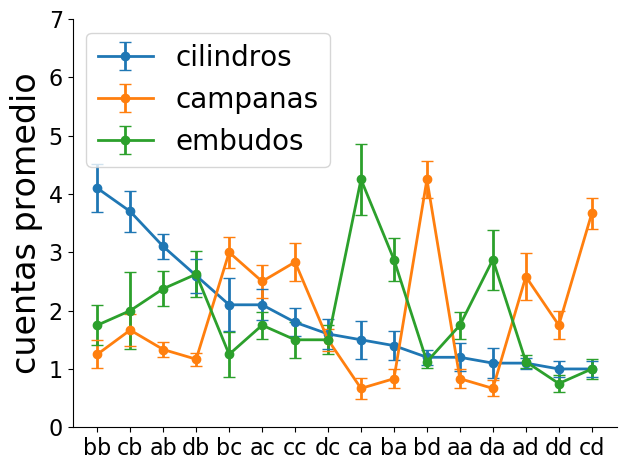

In [5]:
from matplotlib import rc
import seaborn as sns

rc('lines', linewidth=2)
rc('axes', labelsize=24, titlesize=24)
rc('xtick', labelsize=16)
rc('ytick', labelsize=16)

plt.close('all')
fig, ax = plt.subplots()
sns.despine()

dic = {0:'cilindros', 1:'campanas', 2:'embudos'}
for ii in range(3):
    ax.errorbar(x_, X_class.T[:,ii], yerr=(X_class2.T[:,ii]-X_class.T[:,ii]**2.)**.5/tot[ii]**.5, fmt='-o', capsize=4., label=dic[ii])
ax.set_ylabel('cuentas promedio')
ax.legend(loc='best', fontsize=20)
ax.set_ylim(0, 7)
fig.tight_layout()
fig.savefig('./cuentas_clasificador.pdf')
fig